# 8.1

In [15]:
import numpy as np
import pandas as pd
import pydot
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from subprocess import check_call
import pydotplus
import graphviz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


balance_data = pd.read_csv(
'https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data',
                           sep= ',', header= None)

print("Feature Vector Length: ", len(balance_data))
print("Dataset Shape: ", balance_data.shape)

#указываем, где - признаки, где - метка класса
X = balance_data.values[:, 1:5]
Y = balance_data.values[:, 0]

# разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)



Feature Vector Length:  625
Dataset Shape:  (625, 5)


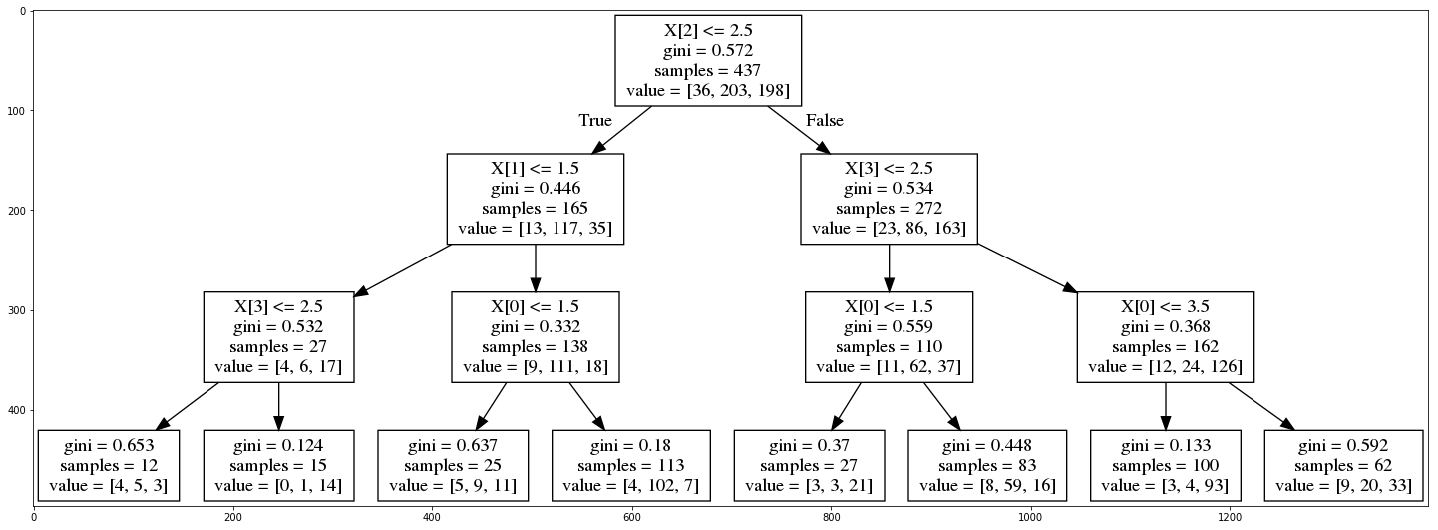

In [22]:
'''
max_depth - глубина дерева
min_samples_leaf - минимальное количество объектов, которое должно быть в листе
max_depth - глубина дерева, по умолчанию ('None') дерево строится до тех пор, пока в каждом листе не останется по одному или 'min_samples_split' объектов (т.е. количества
объектов, достаточного для дальнейшего ветвления узла)
'''

# собственно классификатор и визуализация
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)
#print(clf_gini)
tree.export_graphviz(clf_gini,out_file='tree_gini.dot')
#check_call(['dot','-Tpng','tree_gini.dot','-o','tree_gini.png'])
(graph, ) = pydot.graph_from_dot_file('tree_gini.dot')
graph.write_png('tree_gini.png')
img = mpimg.imread('tree_gini.png')
plt.figure(figsize=(25,25))
imgplot = plt.imshow(img)
plt.show()

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')


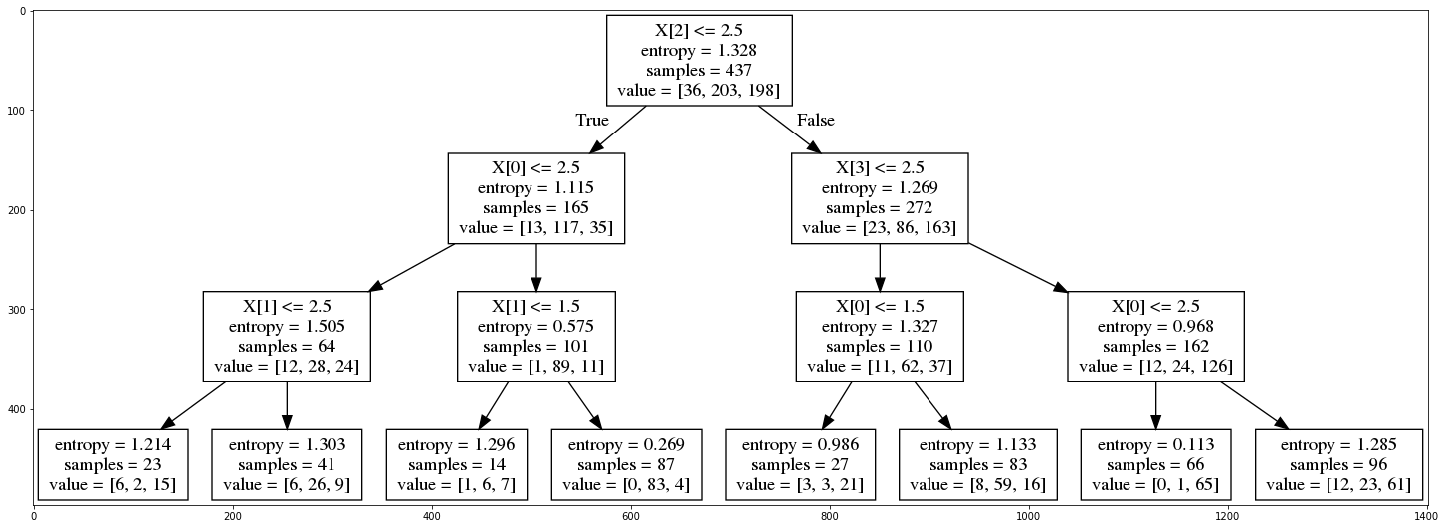

In [23]:
# то же самое, дерево решений строится на основе значений информационного выигрыша
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
clf_entropy.fit(X_train, y_train)
print(clf_entropy)
tree.export_graphviz(clf_entropy,out_file='tree_entropy.dot')
#check_call(['dot','-Tpng','tree_entropy.dot','-o','tree_entropy.png'])
(graph, ) = pydot.graph_from_dot_file('tree_entropy.dot')
graph.write_png('tree_entropy.png')
img = mpimg.imread('tree_entropy.png')
plt.figure(figsize=(25,25))
imgplot = plt.imshow(img)
plt.show()



In [8]:
# классифицируем тестовую выборку
y_pred_gini = clf_gini.predict(X_test)
y_pred_information_gain = clf_entropy.predict(X_test)
#print(y_pred_)gini

#оцениваем точность (accuracy) предсказания
print("Accuracy with entropy param is ", accuracy_score(y_test,y_pred_information_gain))
print("Accuracy with gini param is ", accuracy_score(y_test,y_pred_gini))

Accuracy with entropy param is  0.7074468085106383
Accuracy with gini param is  0.7340425531914894


# 8.2

In [25]:
#import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.datasets import load_iris
#from sklearn.tree import DecisionTreeClassifier

#iris = load_iris()
#X = iris.data
#y = iris.target
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
#estimator.fit(X_train, y_train)
estimator = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)
estimator.fit(X_train, y_train)

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

# описание структуры дерева
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# индикатор узла
node_indicator = estimator.decision_path(X_test)

# id листа
leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] != node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 2] <= 2.5 else to node 8.
	node=1 test node: go to node 2 if X[:, 1] <= 1.5 else to node 5.
		node=2 test node: go to node 3 if X[:, 3] <= 2.5 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 0] <= 1.5 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 3] <= 2.5 else to node 12.
		node=9 test node: go to node 10 if X[:, 0] <= 1.5 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 test node: go to node 13 if X[:, 0] <= 3.5 else to node 14.
			node=13 leaf node.
			node=14 leaf node.

Rules used to predict sample 0: 
decision id node 14 : (X_test[0, -2] (= 3) > -2.0)

The following samples [0, 1] share the node [0] in the tree
It is 6.666666666666667 % of all nodes.


# 8.3

Освоить векторизацию качественных признаков в sklearn  (One-Hot-Encoder(), LabelEncoder()) 
после чего на примере датасета “Титаник” построить дерево решений.

In [29]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
print(enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]]))
print(enc.n_values_)
print(enc.feature_indices_)
print(enc.transform([[0, 1, 1]]).toarray())

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)
[2 3 4]
[0 2 5 9]
[[1. 0. 0. 1. 0. 0. 1. 0. 0.]]


In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
print(list(le.classes_))
print(le.transform(["tokyo", "tokyo", "paris"]))
print(list(le.inverse_transform([2, 2, 1])))

['amsterdam', 'paris', 'tokyo']
[2 2 1]
['tokyo', 'tokyo', 'paris']


/home/ptah/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


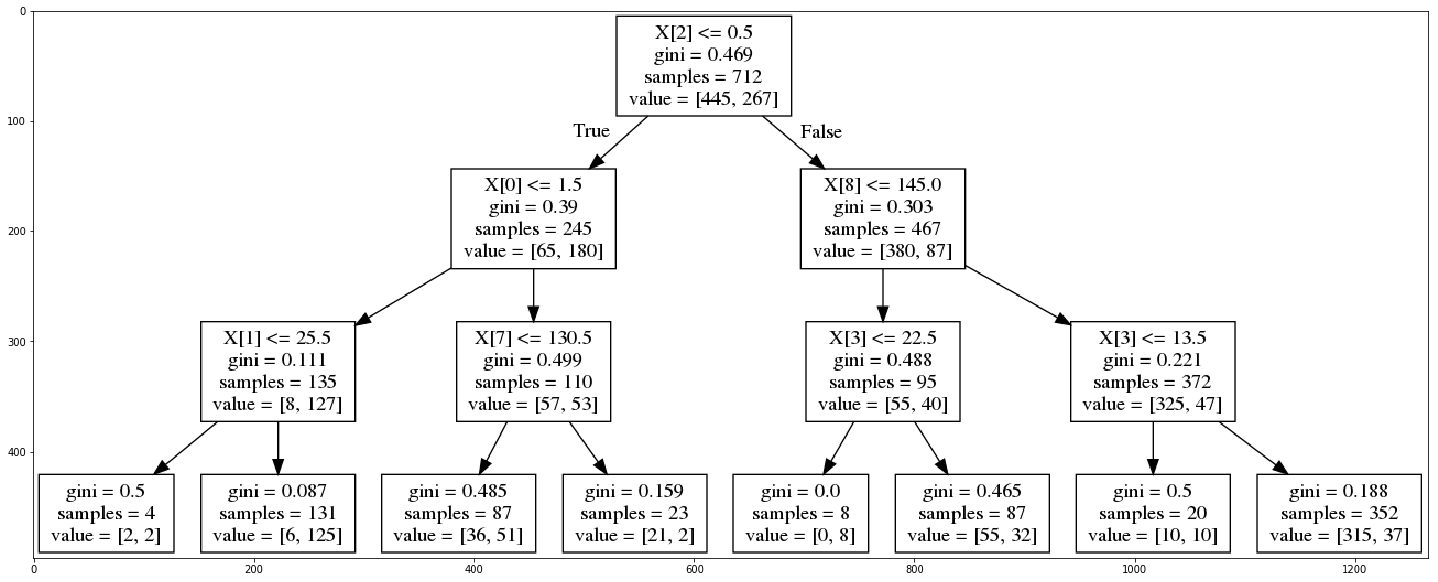

Accuracy: 0.7988826815642458


In [35]:
########################
# titanic tree
########################

data = pd.read_csv('titanic_train.csv', sep=',', header=0, engine='python')
data = data.drop('PassengerId', axis=1)
data_dict = data.to_dict()

y_ = list(data_dict['Survived'].values())
y_ = np.array(y_)

data_clean = []
le = LabelEncoder()
for key in data_dict.keys():
    if key == 'Survived':
        continue
    data = le.fit_transform(list(data_dict[key].values()))
    data_clean.append(data)
    
x_ = np.array(data_clean).T

x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=100)
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=100, max_depth=3, min_samples_leaf=4)
clf_gini.fit(x_train, y_train)

tree.export_graphviz(clf_gini, out_file='tree_gini.dot')
(graph,) = pydot.graph_from_dot_file('tree_gini.dot')
graph.write_png('titanic_tree.png')
img = mpimg.imread('titanic_tree.png')
plt.figure(figsize=(25,25))
imgplot = plt.imshow(img)
plt.show()

y_pred = clf_gini.predict(x_test)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))